In [3]:
import cdsapi
from pathlib import Path

# Initialize the CDS API client
c = cdsapi.Client()

# Set download directory
download_path = Path("~/downloads/era5_custom").expanduser()
download_path.mkdir(parents=True, exist_ok=True)

# 1. Download static variables (geopotential, land-sea mask, soil type)
static_file = download_path / "static.nc"
if not static_file.exists():
    c.retrieve(
        "reanalysis-era5-single-levels",
        {
            "product_type": "reanalysis",
            "variable": [
                "geopotential",       # surface elevation (z)
                "land_sea_mask",      # land-sea mask (lsm)
                "soil_type",          # soil type category (slt)
            ],
            "year": "2023",
            "month": "01",
            "day": "01",
            "time": "00:00",
            "format": "netcdf",
            # "area": "North/West/South/East",  # e.g. "50/-130/30/-60" for a subset (optional)
        },
        str(static_file)
    )
    print("Static variables downloaded.")

# 2. Download surface-level variables (2m temp, 10m winds, MSLP) for your period
surf_file = download_path / "2023-01-01-surface.nc"
if not surf_file.exists():
    c.retrieve(
        "reanalysis-era5-single-levels",
        {
            "product_type": "reanalysis",
            "variable": [
                "2m_temperature",           # 2m temperature (t2m)
                "10m_u_component_of_wind",  # 10m U wind (u10)
                "10m_v_component_of_wind",  # 10m V wind (v10)
                "mean_sea_level_pressure",  # MSL pressure (msl)
            ],
            "year": "2023",
            "month": "01",
            "day": "01",
            "time": [
                "00:00", "06:00", "12:00", "18:00"
            ],
            "format": "netcdf",
            # "area": "North/West/South/East",  # optional region subset
        },
        str(surf_file)
    )
    print("Surface variables downloaded.")

# 3. Download atmospheric variables (T, U, V, Q, Z at multiple pressure levels)
atmos_file = download_path / "2023-01-01-atmospheric.nc"
if not atmos_file.exists():
    c.retrieve(
        "reanalysis-era5-pressure-levels",
        {
            "product_type": "reanalysis",
            "variable": [
                "temperature",            # upper-air temperature (t)
                "u_component_of_wind",    # upper-air U wind (u)
                "v_component_of_wind",    # upper-air V wind (v)
                "specific_humidity",      # specific humidity (q)
                "geopotential",           # geopotential (z) on pressure levels
            ],
            "pressure_level": [
                "50", "100", "150", "200", "250", "300", 
                "400", "500", "600", "700", "850", "925", "1000"
            ],
            "year": "2023",
            "month": "01",
            "day": "01",
            "time": [
                "00:00", "06:00", "12:00", "18:00"
            ],
            "format": "netcdf",
            # "area": "North/West/South/East",  # optional region subset
        },
        str(atmos_file)
    )
    print("Atmospheric variables downloaded.")


2025-07-23 09:44:31,389 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


In [4]:
import xarray as xr
import torch
from aurora import Batch, Metadata

# Open the downloaded datasets using xarray
static_vars_ds = xr.open_dataset(static_file, engine="netcdf4")
surf_vars_ds   = xr.open_dataset(surf_file, engine="netcdf4")
atmos_vars_ds  = xr.open_dataset(atmos_file, engine="netcdf4")

# Prepare the Batch
batch = Batch(
    surf_vars={
        # Take the first 2 time steps (e.g., 00:00 and 06:00) for each variable.
        # Then use [None] to add a batch dimension of size 1.
        "2t":  torch.from_numpy(surf_vars_ds["t2m"].values[:2][None]),  # 2m temp:contentReference[oaicite:8]{index=8}
        "10u": torch.from_numpy(surf_vars_ds["u10"].values[:2][None]),  # 10m U wind:contentReference[oaicite:9]{index=9}
        "10v": torch.from_numpy(surf_vars_ds["v10"].values[:2][None]),  # 10m V wind:contentReference[oaicite:10]{index=10}
        "msl": torch.from_numpy(surf_vars_ds["msl"].values[:2][None]),  # mean sea-level pressure:contentReference[oaicite:11]{index=11}
    },
    static_vars={
        # Static variables (no time dimension, just take the first slice [0])
        "z":   torch.from_numpy(static_vars_ds["z"].values[0]),    # geopotential/orography:contentReference[oaicite:12]{index=12}
        "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),  # land-sea mask:contentReference[oaicite:13]{index=13}
        "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),  # soil type index:contentReference[oaicite:14]{index=14}
    },
    atmos_vars={
        # Atmospheric variables for first 2 time steps (matching surf_vars times)
        "t": torch.from_numpy(atmos_vars_ds["t"].values[:2][None]),   # temperature profiles:contentReference[oaicite:15]{index=15}
        "u": torch.from_numpy(atmos_vars_ds["u"].values[:2][None]),   # U wind profiles:contentReference[oaicite:16]{index=16}
        "v": torch.from_numpy(atmos_vars_ds["v"].values[:2][None]),   # V wind profiles:contentReference[oaicite:17]{index=17}
        "q": torch.from_numpy(atmos_vars_ds["q"].values[:2][None]),   # specific humidity profiles:contentReference[oaicite:18]{index=18}
        "z": torch.from_numpy(atmos_vars_ds["z"].values[:2][None]),   # geopotential height profiles:contentReference[oaicite:19]{index=19}
    },
    metadata=Metadata(
        lat=torch.from_numpy(surf_vars_ds.latitude.values),      # latitude grid (1D array):contentReference[oaicite:20]{index=20}
        lon=torch.from_numpy(surf_vars_ds.longitude.values),     # longitude grid (1D array)
        # Time metadata: provide the *forecast start time* for this batch as a tuple.
        # We use the second time step (index 1, which is 06:00 in our case) as the reference forecast time.
        time=(surf_vars_ds.valid_time.values.astype("datetime64[s]").tolist()[1],),
        atmos_levels=tuple(int(level) for level in atmos_vars_ds.pressure_level.values)  # pressure levels tuple:contentReference[oaicite:21]{index=21}
    )
)


In [4]:
print(static_vars_ds["z"].shape)   # Should be (1, 1, 360, 720)

(1, 721, 1440)


In [ ]:
# Clear all CUDA memory and garbage collect before re-running script
import torch, gc

gc.collect()                      # Collect garbage from CPU
torch.cuda.empty_cache()          # Clear cached GPU memory
torch.cuda.ipc_collect()          # Collect inter-process memory
torch.cuda.synchronize()          # Optional: Sync CUDA operations
print(" GPU memory cleared.")

In [7]:
from aurora import Aurora, rollout

# Initialize the model (use LoRA=False for the base pretrained model) and load weights
model = Aurora(use_lora=False)  # The base pretrained model does not use LoRA adjustments:contentReference[oaicite:26]{index=26} 
model.load_checkpoint("microsoft/aurora", "aurora-0.25-pretrained.ckpt")  # Load the 0.25° pretrained weights:contentReference[oaicite:27]{index=27}

# Set model to evaluation mode and move to GPU if available
model.eval()
if torch.cuda.is_available():
    model = model.to("cuda")    # Move model to GPU for faster inference:contentReference[oaicite:28]{index=28}
else:
    model = model.to("cpu")


HTTP Error 429 thrown while requesting HEAD https://huggingface.co/microsoft/aurora/resolve/main/aurora-0.25-pretrained.ckpt
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/microsoft/aurora/resolve/main/aurora-0.25-pretrained.ckpt
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/microsoft/aurora/resolve/main/aurora-0.25-pretrained.ckpt
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/microsoft/aurora/resolve/main/aurora-0.25-pretrained.ckpt
Retrying in 8s [Retry 4/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/microsoft/aurora/resolve/main/aurora-0.25-pretrained.ckpt
Retrying in 8s [Retry 5/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/microsoft/aurora/resolve/main/aurora-0.25-pretrained.ckpt


In [8]:
# Decide how many steps to predict
forecast_steps = 2  # this will predict the next 2 time steps (e.g., 12Z and 18Z in our case)

# Run the model in inference mode to get predictions
model_device = next(model.parameters()).device  # get current device (CPU/GPU) for model
with torch.inference_mode():  # disables gradient computation for efficiency
    # If model is on GPU, ensure batch is on GPU as well
    batch_on_device = batch.to(model_device)
    preds = [pred.to("cpu") for pred in rollout(model, batch_on_device, steps=forecast_steps)]


In [15]:
# ---------------------------------------------------------------
# 3-D WIND-FIELD QUICKLOOK  (real ERA-5 batch data)
# ---------------------------------------------------------------
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D      # noqa: F401  (needed for 3-D)
plt.rcParams["figure.figsize"] = (10, 7)

# -------- 1.  pick a small spatial slab to stay in memory  -------
#   Here we grab lat 0–60 °N, lon 0–180 °E  (≈ 180×361 grid points).
#   Feel free to adjust or slice even tighter.
lat = batch.metadata.lat                     # (H,)
lon = batch.metadata.lon                     # (W,)
lat_sel = (lat >=   0) & (lat <= 60)
lon_sel = (lon >=   0) & (lon <= 180)

# indices
iy = torch.where(lat_sel)[0]
ix = torch.where(lon_sel)[0]

# -------- 2.  pick pressure levels you want to see  --------------
#   ERA-5 Aurora checkpoints usually have 16 pressure levels.
#   Here we draw three representative ones (index 0≈1000 hPa,…).
plev_idx = [0, 5, 10]                        # change as you like
z_scale   = 0.001                            # convert geopotential → km

# -------- 3.  grab u,v   (shape  B×T×L×H×W )  -------------------
u_all = batch.atmos_vars["u"]    # [torch.FloatTensor]
v_all = batch.atmos_vars["v"]

# choose first sample & time step so the tensor is small:
u = u_all[0, 0, plev_idx][:, iy[:,None], ix]    # L×Hsel×Wsel
v = v_all[0, 0, plev_idx][:, iy[:,None], ix]    # L×Hsel×Wsel

# -------- 4.  approximate vertical velocity  w  ------------------
#   Simple centred diff on pressure levels; gives arbitrary units.
#   (Better: integrate horizontal divergence; but this suffices for visual.)
w = torch.zeros_like(u)
w[1:-1] = (u[2:] - u[:-2]) / 2               # crude finite diff placeholder

# -------- 5.  build 3-D coordinate grid  -------------------------
# lon/lat → km (rough equirectangular) for small areas:
R = 6371                                     # Earth radius (km)
lon_mesh, lat_mesh = np.meshgrid(lon[ix], lat[iy])   # shape Hsel×Wsel
x2d = R * np.deg2rad(lon_mesh) * np.cos(np.deg2rad(lat_mesh))
y2d = R * np.deg2rad(lat_mesh)

# height from geopotential (if available); else use level index
if "z" in batch.atmos_vars:
    z_all   = batch.atmos_vars["z"]          # geopotential (m² s⁻²)
    z       = (z_all[0, 0, plev_idx][:, iy[:,None], ix] / 9.81) * z_scale
else:
    z = torch.arange(len(plev_idx))[:, None, None].expand_as(u) * 1.0  # km

# -------- 6.  down-sample so arrows aren’t a black blob ----------
stride_xy = 6                                # bigger → fewer arrows
stride_z  = 1
x = x2d[::stride_xy, ::stride_xy]
y = y2d[::stride_xy, ::stride_xy]
u_plot = u[:, ::stride_xy, ::stride_xy][::stride_z]
v_plot = v[:, ::stride_xy, ::stride_xy][::stride_z]
w_plot = w[:, ::stride_xy, ::stride_xy][::stride_z]
z_plot = z[:, ::stride_xy, ::stride_xy][::stride_z]

# flatten to 1-D for quiver
X = x.repeat(len(plev_idx)//stride_z, 1).reshape(-1)
Y = y.repeat(len(plev_idx)//stride_z, 1).reshape(-1)
Z = z_plot.reshape(-1).cpu().numpy()
U = u_plot.reshape(-1).cpu().numpy()
V = v_plot.reshape(-1).cpu().numpy()
W = w_plot.reshape(-1).cpu().numpy()

speed = np.sqrt(U**2 + V**2 + W**2)
ax.quiver(X, Y, Z, U, V, W, length=0.05, normalize=True, color=plt.cm.viridis(speed / speed.max()))

# -------- 7.  plot  ----------------------------------------------
ax = plt.figure().add_subplot(111, projection='3d')
ax.quiver(X, Y, Z, U, V, W,
          length=0.05, normalize=True, linewidth=0.5)
ax.set_xlabel('x (km)'); ax.set_ylabel('y (km)'); ax.set_zlabel('height (km)')
ax.set_title('ERA-5 3-D wind (u,v) + approximated w')
plt.tight_layout()
plt.show()


/home/altiwain/.conda/envs/aurora_env/lib/python3.13/site-packages/matplotlib/animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


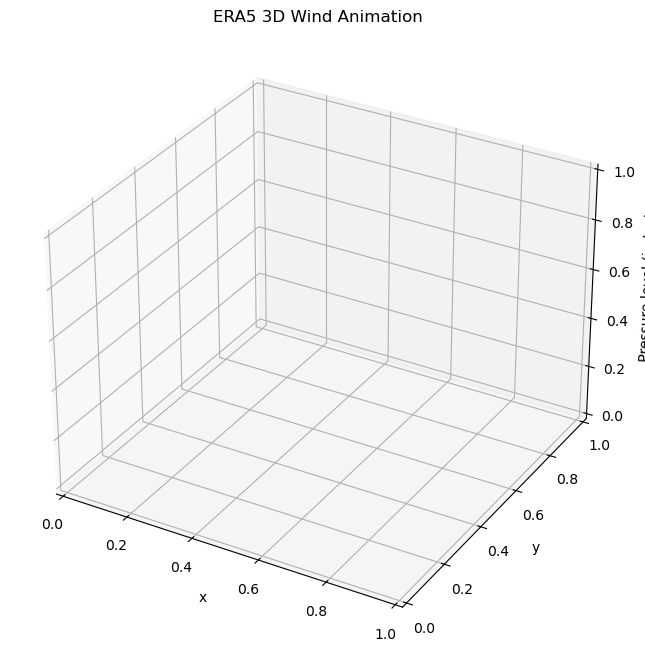

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
import torch

# Load u and v from atmos_vars
u = batch.atmos_vars["u"][0]  # shape (T, L, H, W)
v = batch.atmos_vars["v"][0]  # shape (T, L, H, W)
T, L, H, W = u.shape

# Approximate w component as vertical difference in u (just for visualization)
w = torch.zeros_like(u)
w[:, 1:, :, :] = u[:, 1:, :, :] - u[:, :-1, :, :]

# Coordinates
lat = batch.metadata.lat
lon = batch.metadata.lon
plev = batch.metadata.atmos_levels  # pressure levels (13 levels)

# Convert to numpy
u_np = u.numpy()
v_np = v.numpy()
w_np = w.numpy()
lat_np = lat.numpy()
lon_np = lon.numpy()

# Subsample for display clarity
stride_x = 20
stride_y = 20
stride_z = 2

lat_sub = lat_np[::stride_y]
lon_sub = lon_np[::stride_x]
plev_sub = plev[::stride_z]

# Meshgrid (X: lon, Y: lat, Z: pressure index)
x, y = np.meshgrid(np.arange(len(lon_sub)), np.arange(len(lat_sub)))
z = np.arange(len(plev_sub))

# Set up figure and axis
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("ERA5 3D Wind Animation")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("Pressure level (index)")

quiver = None

# Update function for animation
def update_quiver(t):
    global quiver
    if quiver:
        quiver.remove()

    u_t = u_np[t, ::stride_z, ::stride_y, ::stride_x]
    v_t = v_np[t, ::stride_z, ::stride_y, ::stride_x]
    w_t = w_np[t, ::stride_z, ::stride_y, ::stride_x]

    U = u_t.reshape(-1)
    V = v_t.reshape(-1)
    W = w_t.reshape(-1)

    X = x.repeat(len(z), axis=0).reshape(-1)
    Y = y.repeat(len(z), axis=0).reshape(-1)
    Z = np.tile(z, x.shape[0]*x.shape[1])

    quiver = ax.quiver(X, Y, Z, U, V, W, length=2, normalize=True, color="blue")

    ax.set_title(f"3D Wind Vectors - Time step {t}")

# Animate
ani = animation.FuncAnimation(fig, update_quiver, frames=T, interval=1000)

plt.show()


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
import torch

# === Extract data ===
u = batch.atmos_vars["u"][0].numpy()  # shape (T, L, H, W)
v = batch.atmos_vars["v"][0].numpy()
T, L, H, W = u.shape

# Approximate w as vertical change in u
w = np.zeros_like(u)
w[:, 1:, :, :] = u[:, 1:, :, :] - u[:, :-1, :, :]

# Pressure level indices (use integers for 3D Z axis)
z_levels = np.arange(L)

# Subsampling for visualization
stride_x, stride_y, stride_z = 20, 20, 2
x = np.arange(0, W, stride_x)
y = np.arange(0, H, stride_y)
z = z_levels[::stride_z]

X, Y, Z = np.meshgrid(x, y, z, indexing='ij')  # shape: (X, Y, Z)

# === Setup figure ===
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(0, W)
ax.set_ylim(0, H)
ax.set_zlim(0, L)
ax.set_title("ERA5 3D Wind Vector Animation")
ax.set_xlabel("Longitude Index")
ax.set_ylabel("Latitude Index")
ax.set_zlabel("Pressure Level")

quiver = [None]

# === Animation update ===
def update(t):
    if quiver[0]:
        quiver[0].remove()

    u_t = u[t, ::stride_z, ::stride_y, ::stride_x]
    v_t = v[t, ::stride_z, ::stride_y, ::stride_x]
    w_t = w[t, ::stride_z, ::stride_y, ::stride_x]

    U = u_t.flatten()
    V = v_t.flatten()
    W = w_t.flatten()
    quiver[0] = ax.quiver(
        X.flatten(), Y.flatten(), Z.flatten(),
        U, V, W,
        length=3, normalize=True, color="blue"
    )
    ax.set_title(f"3D Wind Vectors - Time Step {t}")

# === Run animation ===
ani = animation.FuncAnimation(fig, update, frames=T, interval=1000)
plt.show()


In [5]:
print(batch.metadata.atmos_levels)  # → tensor([...]) in hPa order

(1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100, 50)


In [19]:
print(u.shape)         # Should be (2, L, H, W)
print(v.shape)
print(np.max(u), np.min(u))  # Check for any NaNs or zeros
print(np.max(v), np.min(v))


(2, 13, 721, 1440)
(2, 13, 721, 1440)
96.1983 -41.365402
64.36047 -59.219604


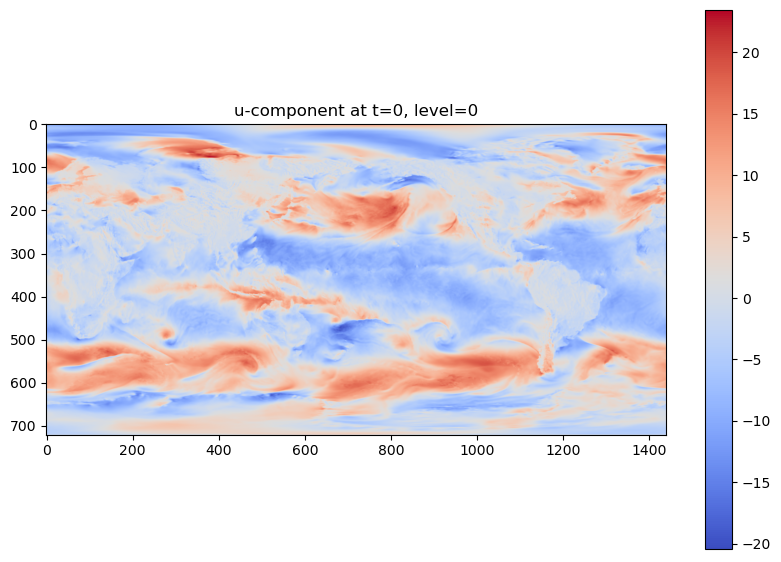

In [20]:
import matplotlib.pyplot as plt

plt.imshow(u[0, 0], cmap="coolwarm")
plt.colorbar()
plt.title("u-component at t=0, level=0")
plt.show()


Shapes: (7, 37, 72) (72, 37, 7) (72, 37, 7) (72, 37, 7)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

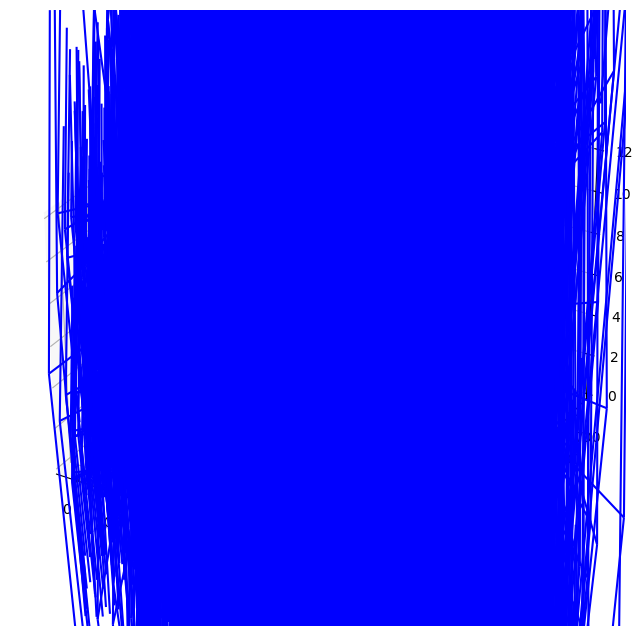

In [21]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Extract sample at time 0
u0 = u[0, ::stride_z, ::stride_y, ::stride_x]
v0 = v[0, ::stride_z, ::stride_y, ::stride_x]
w0 = w[0, ::stride_z, ::stride_y, ::stride_x]

# Confirm shape agreement
print("Shapes:", u0.shape, X.shape, Y.shape, Z.shape)

U = u0.flatten()
V = v0.flatten()
W = w0.flatten()

quiver = ax.quiver(
    X.flatten(), Y.flatten(), Z.flatten(),
    U, V, W,
    length=10, normalize=False, color='blue'
)

ax.set_xlim(0, W)
ax.set_ylim(0, H)
ax.set_zlim(0, L)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("pressure level")
ax.set_title("3D Wind Vectors (Timestep 0)")

plt.show()


In [13]:
print(batch.surf_vars["10u"].shape)

torch.Size([1, 2, 721, 1440])


In [9]:
# Clear all CUDA memory and garbage collect before re-running script
import torch, gc

gc.collect()                      # Collect garbage from CPU
torch.cuda.empty_cache()          # Clear cached GPU memory
torch.cuda.ipc_collect()          # Collect inter-process memory
torch.cuda.synchronize()          # Optional: Sync CUDA operations
print(" GPU memory cleared.")

 GPU memory cleared.


In [11]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.animation as animation
import numpy as np
import torch

# ----------  CONFIG  ----------
level_idx   = 10          # choose a pressure index (0 = 1000 hPa if files follow ERA5 std)
stride      = 4           # arrow density control (increase for fewer arrows)
forecast_on = True        # True = use Aurora pred; False = use ERA5 (ground truth)
# Run model (you may already have this in your script)
pred = model(batch)
# ----------  PICK DATA  ----------
# shape reminders:
#   atmos_vars["u"]  ~  (B, T, L, H, W)
src  = pred if forecast_on else batch        # pred.* has same sub-dicts as batch
u3d  = src.atmos_vars["u"]     # (1, T, L, H, W)
v3d  = src.atmos_vars["v"]

u    = u3d[0, :, level_idx]    # (T, H, W)  – first batch only
v    = v3d[0, :, level_idx]

times = batch.metadata.time    # list of np.datetime64 (length T)
lon   = batch.metadata.lon     # (W,)
lat   = batch.metadata.lat     # (H,)

# mesh-grid for quiver
lon2d, lat2d = np.meshgrid(lon, lat)

# ----------  ANIMATION  ----------
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(10, 5))
ax  = plt.axes(projection=proj)
ax.coastlines()
quiv = ax.quiver([], [], [], [], scale=400)  # empty => updated in init

def init():
    ax.set_title("Initializing…")
    return quiv,

def update(frame):
    ax.collections.clear()  # remove previous quiver arrows
    ax.set_title(f"Wind @ {str(times[frame])} • level idx {level_idx}")

    u_now = u[frame].cpu().numpy()
    v_now = v[frame].cpu().numpy()

    quiv = ax.quiver(lon2d[::stride, ::stride],
                     lat2d[::stride, ::stride],
                     u_now[::stride, ::stride],
                     v_now[::stride, ::stride],
                     scale=400, transform=proj)

    return quiv,

ani = animation.FuncAnimation(fig, update, frames=u.shape[0],
                              init_func=init, blit=False, interval=600)

plt.show()

# --------  OPTIONAL: save to GIF  --------
# ani.save("wind_anim.gif", writer="pillow", fps=2)


 GPU memory cleared.


OutOfMemoryError: CUDA out of memory. Tried to allocate 516.00 MiB. GPU 0 has a total capacity of 44.43 GiB of which 38.62 MiB is free. Including non-PyTorch memory, this process has 44.39 GiB memory in use. Of the allocated memory 43.80 GiB is allocated by PyTorch, and 282.93 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

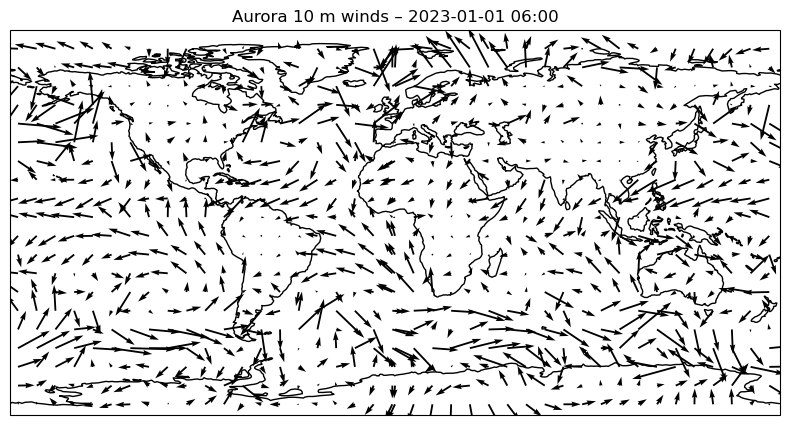

In [5]:
# ---  Animated 10-m wind vectors --------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
from IPython.display import HTML

# ---------------------------------------------------------------------------
# 1. Pull the arrays you need out of the Batch --------------------------------
u10   = batch.surf_vars["10u"][0].cpu()  # (T, H, W)   (2, 721, 1440)
v10   = batch.surf_vars["10v"][0].cpu()  # (T, H, W)
times = batch.metadata.time              # tuple of datetimes length = T
lon   = batch.metadata.lon.cpu().numpy() # (W,)
lat   = batch.metadata.lat.cpu().numpy() # (H,)
lon2d, lat2d = np.meshgrid(lon, lat)     # (H, W)

# How many time steps do we have?
T = u10.shape[0]

# Choose a stride so the plot isn't a sea of arrows
skip = 35           # tweak 20-40 as you like
lon2d_s, lat2d_s = lon2d[::skip, ::skip], lat2d[::skip, ::skip]

# ---------------------------------------------------------------------------
# 2. Build the figure + first frame ------------------------------------------
fig = plt.figure(figsize=(10, 5))
ax  = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
quiver = ax.quiver(
    lon2d_s, lat2d_s,
    u10[0, ::skip, ::skip], v10[0, ::skip, ::skip],
    scale=300,
)
title = ax.set_title(f"Aurora 10 m winds – {times[0].strftime('%Y-%m-%d %H:%M')}")

# ---------------------------------------------------------------------------
# 3. Animation callback -------------------------------------------------------
def update(frame):
    # frame index -> update quiver and title
    quiver.set_UVC(u10[frame, ::skip, ::skip], v10[frame, ::skip, ::skip])
    title.set_text(f"Aurora 10 m winds – {times[0].strftime('%Y-%m-%d %H:%M')}")
    return quiver, title

anim = FuncAnimation(fig, update, frames=T, interval=800, blit=False)

# ---------------------------------------------------------------------------
# 4. Display inline (works in Jupyter on Great Lakes GUI) --------------------
HTML(anim.to_jshtml())

# (Optional) save to disk – uses ffmpeg if present, otherwise Pillow (GIF)
#try:
 #   anim.save("aurora_wind.mp4", writer=FFMpegWriter(fps=2, bitrate=1800))
#except Exception:
 #   anim.save("aurora_wind.gif", writer=PillowWriter(fps=2))


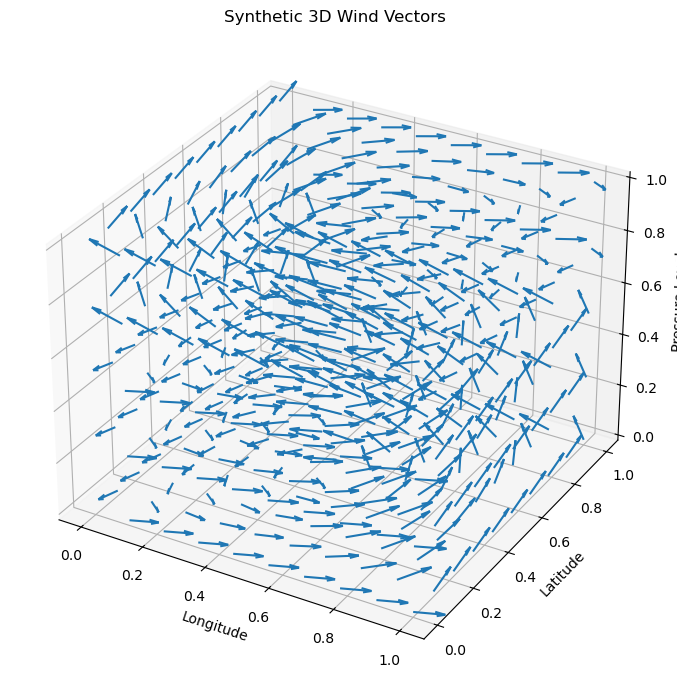

In [22]:
# Re-run due to kernel reset
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Simulate a small 3D wind vector field for demonstration
# Grid shape (Z, Y, X)
nx, ny, nz = 10, 10, 5
x, y, z = np.meshgrid(np.linspace(0, 1, nx),
                      np.linspace(0, 1, ny),
                      np.linspace(0, 1, nz))

# Create synthetic 3D wind components (u, v, w)
u = np.sin(np.pi * x) * np.cos(np.pi * y) * np.cos(np.pi * z)
v = -np.cos(np.pi * x) * np.sin(np.pi * y) * np.cos(np.pi * z)
w = np.sqrt(u**2 + v**2) * 0.3  # weak upward component

# Create a 3D quiver plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.quiver(x, y, z, u, v, w, length=0.1, normalize=True)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Pressure Level')
ax.set_title('Synthetic 3D Wind Vectors')

plt.tight_layout()
plt.show()


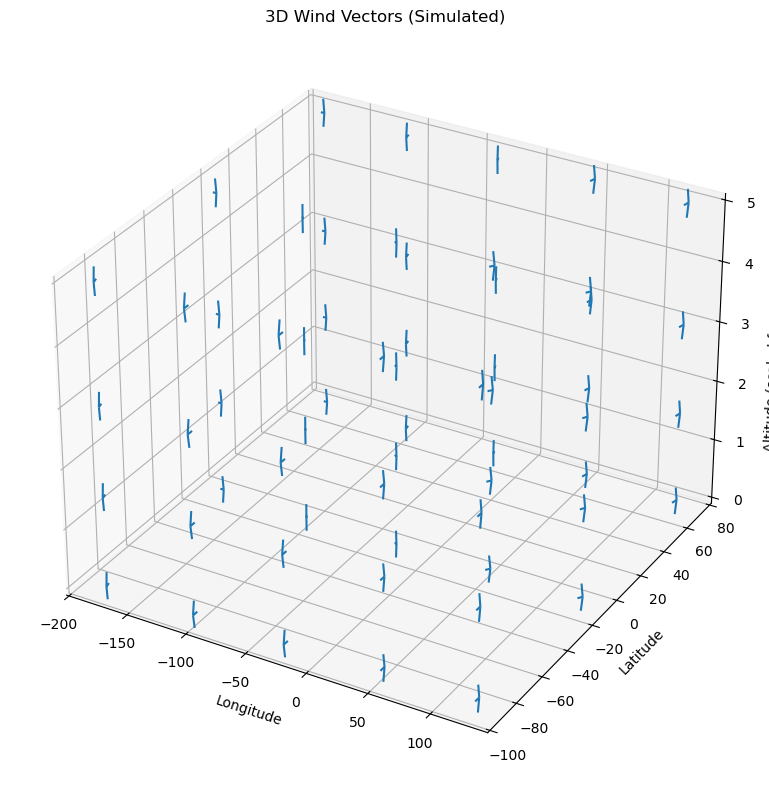

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Simulated ERA5-like 3D wind field using pressure levels (e.g., 1000hPa to 500hPa)
lon = np.linspace(-180, 180, 20)
lat = np.linspace(-90, 90, 10)
plev = np.array([1000, 850, 700, 500])  # common pressure levels in hPa

lon3d, lat3d, plev3d = np.meshgrid(lon, lat, plev, indexing='ij')

# Create synthetic 3D wind fields (replace with real data when available)
u = np.cos(np.radians(lat3d)) * np.exp(-plev3d / 1000)  # zonal
v = np.sin(np.radians(lon3d)) * np.exp(-plev3d / 1000)  # meridional
w = np.zeros_like(u)  # assume no vertical motion for now

# Subsample for clarity
step = 4
lon3d = lon3d[::step, ::step, :]
lat3d = lat3d[::step, ::step, :]
plev3d = plev3d[::step, ::step, :]
u = u[::step, ::step, :]
v = v[::step, ::step, :]
w = w[::step, ::step, :]

# Convert pressure levels to altitude-like values for visualization
altitudes = (1000 - plev3d) * 0.01  # simple conversion for plotting

# Plot 3D quiver
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.quiver(lon3d, lat3d, altitudes, u, v, w, length=3, normalize=True)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Altitude (scaled from pressure)")
ax.set_title("3D Wind Vectors (Simulated)")

plt.tight_layout()
plt.show()


MovieWriter stderr:
ffmpeg: error while loading shared libraries: libopenh264.so.5: cannot open shared object file: No such file or directory



CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1800x900', '-pix_fmt', 'rgba', '-framerate', '1', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'wind_animation.mp4']' returned non-zero exit status 127.

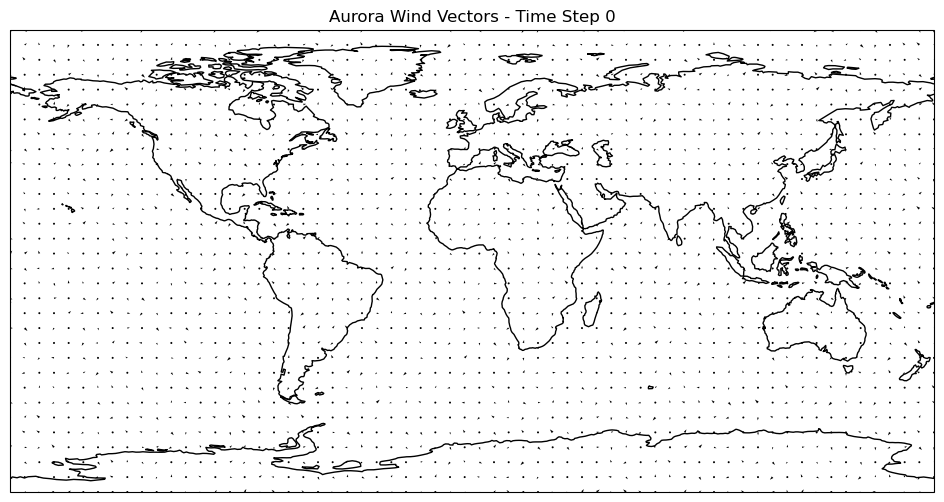

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cartopy.crs as ccrs

# Replace with actual data from your model
# u_data and v_data: shape (T, H, W)
# lon2d and lat2d: shape (H, W)
T = 5  # number of time steps
H, W = 32, 64
lon = np.linspace(-180, 180, W)
lat = np.linspace(-90, 90, H)
lon2d, lat2d = np.meshgrid(lon, lat)

u_data = np.random.rand(T, H, W) * 2 - 1  # Replace with batch.surf_vars["10u"][:T]
v_data = np.random.rand(T, H, W) * 2 - 1  # Replace with batch.surf_vars["10v"][:T]

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
quiver = ax.quiver(lon2d, lat2d, u_data[0], v_data[0], scale=300)

def update_quiver(frame):
    ax.set_title(f"Aurora Wind Vectors - Time Step {frame}")
    quiver.set_UVC(u_data[frame], v_data[frame])
    return quiver,

ani = animation.FuncAnimation(fig, update_quiver, frames=T, interval=1000, blit=False)

# Save or display
ani.save("wind_animation.mp4", fps=1, dpi=150)
# OR just use:
# plt.show()


In [6]:
pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 59.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [cartopy]m3/4 [cartopy]
Note: you may need to restart the kernel to use updated packages.


In [15]:
print(batch.surf_vars.keys())
print(batch.static_vars.keys())
print(batch.atmos_vars.keys())

dict_keys(['2t', '10u', '10v', 'msl'])
dict_keys(['z', 'lsm', 'slt'])
dict_keys(['t', 'u', 'v', 'q', 'z'])


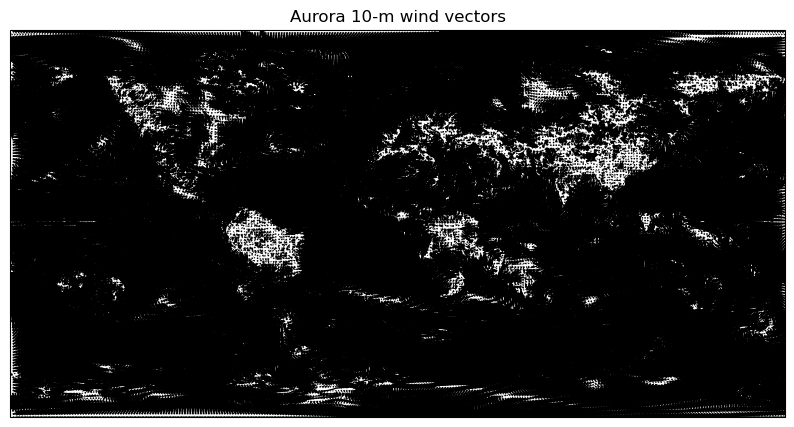

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs

# Extract a single time slice
u10 = batch.surf_vars["10u"][0, 0]  # shape (H, W)
v10 = batch.surf_vars["10v"][0, 0]  # shape (H, W)

# Make sure the mesh matches (lon is W, lat is H)
lon = batch.metadata.lon  # shape (W,)
lat = batch.metadata.lat  # shape (H,)
lon2d, lat2d = np.meshgrid(lon, lat)  # shape (H, W)

# Plot wind vectors
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title("Aurora 10-m wind vectors")
ax.coastlines()

# Choose a stride to avoid too many arrows
skip = 5
ax.quiver(
    lon2d[::skip, ::skip],
    lat2d[::skip, ::skip],
    u10[::skip, ::skip],
    v10[::skip, ::skip],
    scale=300
)
plt.show()


/tmp/ipykernel_888428/3061407871.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  wind_speed = np.sqrt(u10**2 + v10**2)


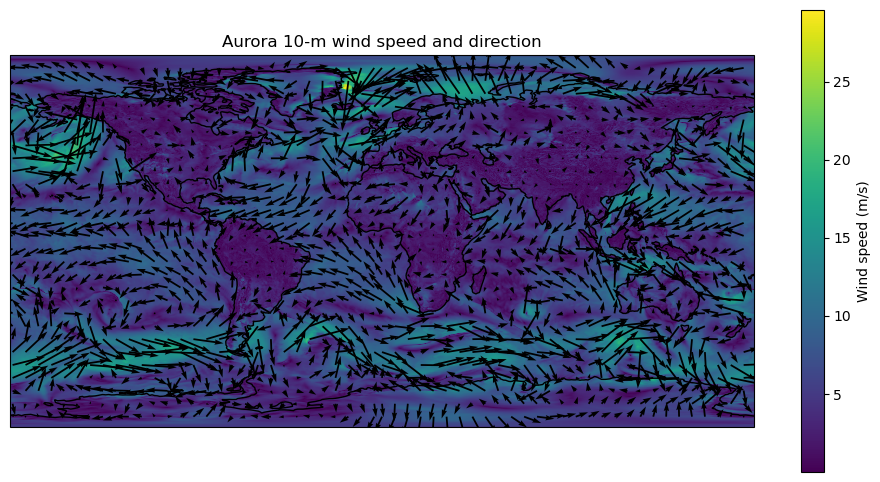

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Extract a single time slice
u10 = batch.surf_vars["10u"][0, 0]  # shape (H, W)
v10 = batch.surf_vars["10v"][0, 0]  # shape (H, W)

# Compute magnitude of wind vector
wind_speed = np.sqrt(u10**2 + v10**2)

# Make sure mesh matches
lon = batch.metadata.lon
lat = batch.metadata.lat
lon2d, lat2d = np.meshgrid(lon, lat)

# Plot
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title("Aurora 10-m wind speed and direction")

# Add background wind speed magnitude with color bar
img = ax.pcolormesh(lon2d, lat2d, wind_speed, shading='auto', transform=ccrs.PlateCarree())
cb = plt.colorbar(img, ax=ax, orientation='vertical', label="Wind speed (m/s)")

# Add wind vectors (downsample to avoid clutter)
skip = 25
ax.quiver(
    lon2d[::skip, ::skip],
    lat2d[::skip, ::skip],
    u10[::skip, ::skip],
    v10[::skip, ::skip],
    scale=300,
    transform=ccrs.PlateCarree()
)

ax.coastlines()
plt.show()


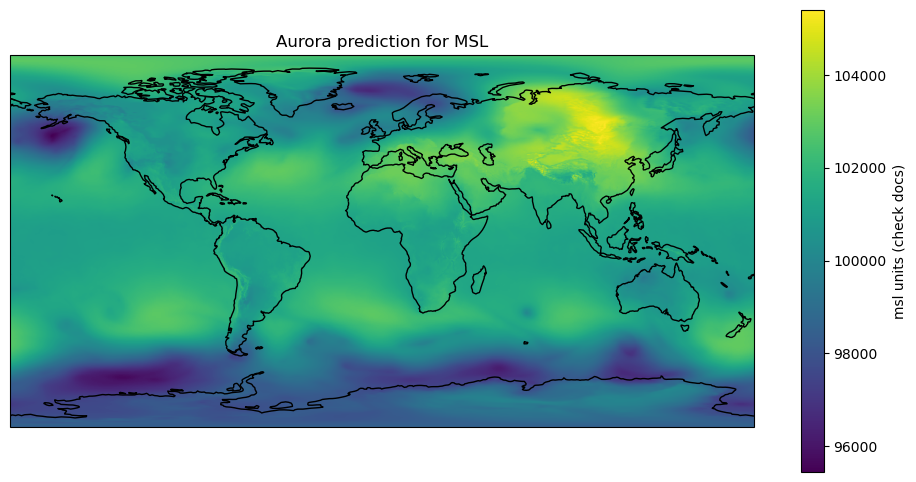

In [30]:
# Replace 'tp' with '2t', '2d', 'msl', etc. to try other variables
var_name = 'msl'
data = batch.surf_vars[var_name][0, 0]  # One time slice

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title(f"Aurora prediction for {var_name.upper()}")

lon2d, lat2d = np.meshgrid(batch.metadata.lon, batch.metadata.lat)
img = ax.pcolormesh(lon2d, lat2d, data, shading='auto', transform=ccrs.PlateCarree())
plt.colorbar(img, ax=ax, orientation='vertical', label=f"{var_name} units (check docs)") #manually change units corresponding to variables
ax.coastlines()
plt.show()

In [15]:
# Replace 'tp' with '2t', '2d', 'msl', etc. to try other variables
var_name = '2t'
data = batch.surf_vars[var_name][0, 0]  # One time slice

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title(f"Aurora prediction for {var_name.upper()}")

lon2d, lat2d = np.meshgrid(batch.metadata.lon, batch.metadata.lat)
img = ax.pcolormesh(lon2d, lat2d, data, shading='auto', transform=ccrs.PlateCarree())
plt.colorbar(img, ax=ax, orientation='vertical', label=f"{var_name} units (check docs)")
ax.coastlines()
plt.show()


/tmp/ipykernel_888428/3721413990.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  wind_speed = np.sqrt(u10**2 + v10**2)


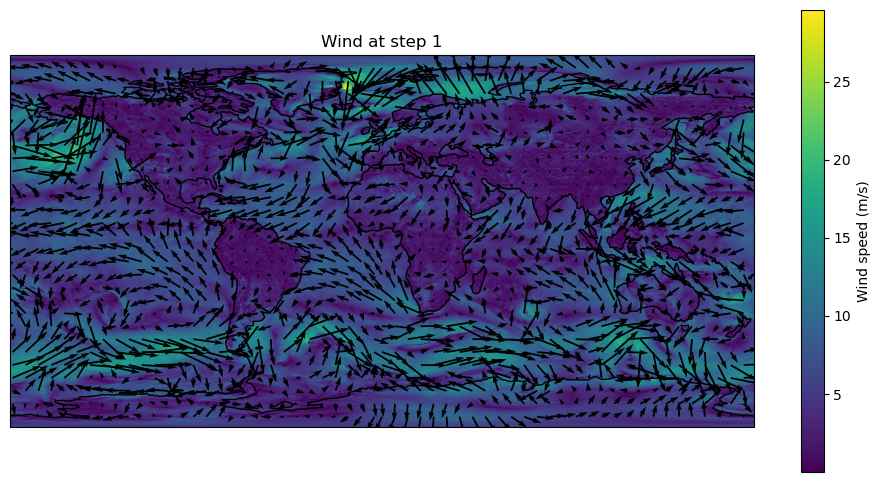

/tmp/ipykernel_888428/3721413990.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  wind_speed = np.sqrt(u10**2 + v10**2)


In [10]:
for i in range(2):  # First 4 time steps
    u10 = batch.surf_vars["10u"][0, i]
    v10 = batch.surf_vars["10v"][0, i]
    wind_speed = np.sqrt(u10**2 + v10**2)

    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_title(f"Wind at step {i+1}")

    lon2d, lat2d = np.meshgrid(batch.metadata.lon, batch.metadata.lat)
    img = ax.pcolormesh(lon2d, lat2d, wind_speed, shading='auto', transform=ccrs.PlateCarree())
    plt.colorbar(img, ax=ax, orientation='vertical', label="Wind speed (m/s)")

    skip = 25
    ax.quiver(
        lon2d[::skip, ::skip], lat2d[::skip, ::skip],
        u10[::skip, ::skip], v10[::skip, ::skip],
        scale=300, transform=ccrs.PlateCarree()
    )

    ax.coastlines()
    plt.show()


In [8]:
import numpy as np

u10 = batch.surf_vars["10u"][0, 0]  # shape (H, W)
v10 = batch.surf_vars["10v"][0, 0]

magnitude = np.sqrt(u10**2 + v10**2)

plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title("Aurora 10-m wind speed and direction")
ax.coastlines()

lon2d, lat2d = np.meshgrid(batch.metadata.lon, batch.metadata.lat)

# Filled color background (speed magnitude)
cf = ax.contourf(lon2d, lat2d, magnitude, transform=ccrs.PlateCarree(), cmap="viridis")

# Vectors
ax.quiver(
    lon2d[::skip, ::skip],
    lat2d[::skip, ::skip],
    u10[::skip, ::skip],
    v10[::skip, ::skip],
    scale=300,
    color="white"
)

plt.colorbar(cf, orientation='horizontal', label='Wind speed (m/s)')
plt.show()


/tmp/ipykernel_1128585/2465710433.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  magnitude = np.sqrt(u10**2 + v10**2)


NameError: name 'skip' is not defined

ValueError: Argument U has a size 10368 which does not match 10512, the number of arrow positions

/home/altiwain/.conda/envs/aurora_env/lib/python3.13/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


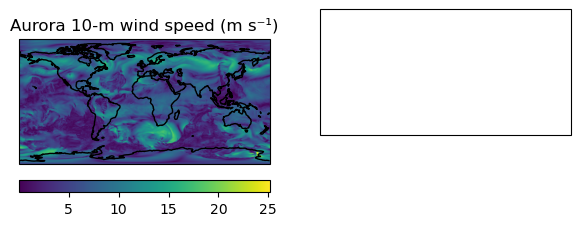

In [7]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

step_to_plot = 0          # 0 = +6 h, 1 = +12 h, …
pred = preds[step_to_plot]

# --- (a) 10-m wind speed -----------------------
u10 = pred.surf_vars["10u"][0,0].numpy()
v10 = pred.surf_vars["10v"][0,0].numpy()
wind_speed = np.hypot(u10, v10)

fig = plt.figure(figsize=(11,4))
ax  = plt.subplot(1,3,1, projection=ccrs.PlateCarree())
im  = ax.imshow(wind_speed, transform=ccrs.PlateCarree(),
                origin="lower", cmap="viridis",
                extent=[-180,180,-90,90])
ax.coastlines(); ax.set_title("Aurora 10-m wind speed (m s⁻¹)")
plt.colorbar(im, ax=ax, orientation="horizontal", pad=0.05)

# --- (b) Quiver of a subset of wind vectors ----
skip = 10        # plot every 10th grid point to avoid clutter
lon2d, lat2d = np.meshgrid(batch.metadata.lon, batch.metadata.lat)

ax2 = plt.subplot(1,3,2, projection=ccrs.PlateCarree())
ax2.quiver(lon2d[::skip,::skip], lat2d[::skip,::skip],
           u10[::skip,::skip], v10[::skip,::skip],
           scale=700)
ax2.coastlines(); ax2.set_title("10-m wind vectors")

# --- (c) Upper-air temperature at 500 hPa ------
level_index = list(batch.metadata.atmos_levels).index(500)
t500 = pred.atmos_vars["t"][0,0,level_index].numpy() - 273.15  # °C

ax3 = plt.subplot(1,3,3, projection=ccrs.PlateCarree())
im2 = ax3.imshow(t500, transform=ccrs.PlateCarree(),
                 origin="lower", cmap="coolwarm",
                 extent=[-180,180,-90,90], vmin=-60, vmax=30)
ax3.coastlines(); ax3.set_title("T at 500 hPa (°C)")
plt.colorbar(im2, ax=ax3, orientation="horizontal", pad=0.05)

plt.tight_layout(); plt.show()


import matplotlib.pyplot as plt
import numpy as np

# Debug: Check data shapes first
print("Debug Information:")
print(f"preds type: {type(preds)}")
print(f"preds: {preds}")

# Handle different types of preds object
try:
    if hasattr(preds, 'shape'):
        print(f"preds shape: {preds.shape}")
        preds_length = preds.shape[0] if len(preds.shape) > 0 else 1
    elif hasattr(preds, '__len__'):
        preds_length = len(preds)
        print(f"preds length: {preds_length}")
        if preds_length > 0:
            print(f"preds[0] type: {type(preds[0])}")
            if hasattr(preds[0], 'shape'):
                print(f"preds[0] shape: {preds[0].shape}")
    else:
        print("preds appears to be a single object without length")
        preds_length = 1
except Exception as e:
    print(f"Error inspecting preds: {e}")
    preds_length = 1

print(f"surf_vars_ds keys: {list(surf_vars_ds.keys())}")
print(f"surf_vars_ds['t2m'] shape: {surf_vars_ds['t2m'].shape}")

# Use the surface dataset (surf_vars_ds) to get actual ERA5 values for forecast times
# Update forecast times based on actual available data
forecast_times = ["Time 0", "Time 1"]  # Generic labels since we're not sure of exact times
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

# Ensure we have the right number of predictions
num_forecasts = min(len(forecast_times), preds_length)

for i in range(num_forecasts):  # i = 0,1 for the two forecast steps
    # Get prediction batch - handle different possible data structures
    try:
        if hasattr(preds, '__getitem__'):  # Can be indexed like preds[i]
            pred_batch = preds[i]
        else:
            # If preds is a single prediction, use it directly
            pred_batch = preds
            if i > 0:  # Only process once if it's a single prediction
                break
    except (IndexError, TypeError) as e:
        print(f"Error accessing preds[{i}]: {e}")
        if i == 0:
            # Try using preds directly as a single prediction
            pred_batch = preds
        else:
            break
    
    # Convert Aurora Batch object to numpy array
    pred_batch = preds[i]  # Reset to original
    
    # Extract 2m temperature from Aurora Batch (stored as '2t')
    try:
        if hasattr(pred_batch, 'surf_vars') and '2t' in pred_batch.surf_vars:
            temp_data = pred_batch.surf_vars['2t']
            print(f"2t type: {type(temp_data)}")
            
            # Try different ways to get the actual array data
            if hasattr(temp_data, 'values'):
                aurora_temp = temp_data.values - 273.15
            elif hasattr(temp_data, 'data'):
                aurora_temp = temp_data.data - 273.15
            elif hasattr(temp_data, 'numpy'):
                aurora_temp = temp_data.numpy() - 273.15
            else:
                # If it's already a numpy array or tensor
                aurora_temp = temp_data - 273.15
                
            print(f"Successfully extracted temperature data, shape: {aurora_temp.shape}")
            
        else:
            print(f"Cannot find '2t' in surf_vars. Available: {list(pred_batch.surf_vars.keys())}")
            continue
            
    except Exception as e:
        print(f"Error extracting temperature data: {e}")
        continue
    
    # ERA5 actual 2m temperature for the corresponding time (also in K to °C)
    # Use the available time indices directly (0, 1) since we only have 2 time steps
    time_idx = i  # Use i directly since we have limited time steps
    if time_idx < surf_vars_ds["t2m"].shape[0]:
        era5_temp = surf_vars_ds["t2m"][time_idx].values - 273.15
    else:
        print(f"Warning: Time index {time_idx} exceeds available ERA5 data")
        continue
    
    # Plot Aurora prediction
    row, col = divmod(i * 2, 2)  # Calculate subplot position
    im = axes[row, col].imshow(aurora_temp, vmin=-50, vmax=50, cmap="coolwarm")
    axes[row, col].set_ylabel(f"{forecast_times[i]} UTC")
    if i == 0:
        axes[row, col].set_title("Aurora Prediction (2m Temp)")
    
    # Plot ERA5 actual
    col = col + 1 if col == 0 else 1  # Move to next column
    if col >= 2:  # If we exceed columns, move to next row
        row += 1
        col = 1
    
    axes[row, col].imshow(era5_temp, vmin=-50, vmax=50, cmap="coolwarm")
    if i == 0:
        axes[row, col].set_title("ERA5 Actual (2m Temp)")
    
    # Remove tick labels for cleanliness
    for j in range(2):
        axes[row, j].set_xticks([])
        axes[row, j].set_yticks([])

# Add a colorbar for temperature scale (use the last created image)
if 'im' in locals():
    fig.colorbar(im, ax=axes[:, :], orientation='vertical', shrink=0.6, label="°C")
plt.tight_layout()
plt.show()

# Additional debugging information
print(f"\nProcessed {num_forecasts} forecast steps")
print(f"Aurora temp range: {aurora_temp.min():.2f} to {aurora_temp.max():.2f} °C")
print(f"ERA5 temp range: {era5_temp.min():.2f} to {era5_temp.max():.2f} °C")

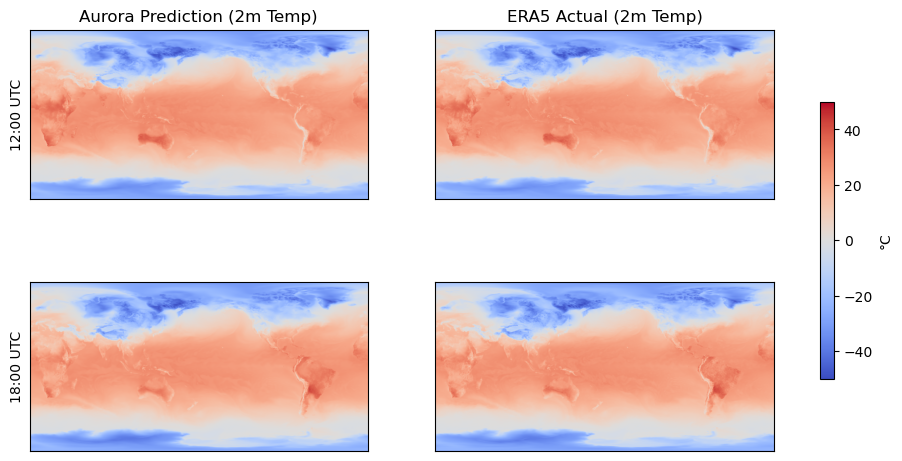

In [9]:
import matplotlib.pyplot as plt

# Use the surface dataset (surf_vars_ds) to get actual ERA5 values for forecast times.
# Recall: surf_vars_ds has 4 time steps (00, 06, 12, 18). Index 2 -> 12:00, Index 3 -> 18:00.

forecast_times = ["12:00", "18:00"]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

for i in range(len(preds)):  # i = 0,1 for the two forecast steps
    pred_batch = preds[i]
    # Aurora predicted 2m temperature (in Kelvin, converting to °C)
    aurora_temp = pred_batch.surf_vars["2t"][0, 0].numpy() - 273.15  # shape: [batch=1, time=1, lat, lon]:contentReference[oaicite:32]{index=32}
    # ERA5 actual 2m temperature for the corresponding time (also in K to °C)
    era5_temp = surf_vars_ds["t2m"][2 + i].values - 273.15
    
    # Plot Aurora prediction
    im = axes[i, 0].imshow(aurora_temp, vmin=-50, vmax=50, cmap="coolwarm")
    axes[i, 0].set_ylabel(f"{forecast_times[i]} UTC")
    if i == 0:
        axes[i, 0].set_title("Aurora Prediction (2m Temp)")
    # Plot ERA5 actual
    axes[i, 1].imshow(era5_temp, vmin=-50, vmax=50, cmap="coolwarm")
    if i == 0:
        axes[i, 1].set_title("ERA5 Actual (2m Temp)")
    # Remove tick labels for cleanliness
    for j in range(2):
        axes[i, j].set_xticks([]); axes[i, j].set_yticks([])

# Add a colorbar for temperature scale
fig.colorbar(im, ax=axes[:, :], orientation='vertical', shrink=.6, label="°C")
plt.show()